In [1]:
# Загружаем необходимые библиотеки 
# Библиотека для работы с функциями операционной системы
import os

# Даталоадер
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# Загрузка изображений 
from torchvision.datasets import ImageFolder
# Функции трансформации изображений, сохранения и компоновки 
import torchvision.transforms as tt
from torchvision.utils import save_image
from torchvision.utils import make_grid

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

# Общего применения 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)
import itertools
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output


# from torch.autograd import Variable
# import cv2


## 0. Настройки видеокарты 

In [2]:
# Смотрим видеокарты установленные в системе 
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce RTX 3060
NVIDIA GeForce GTX 1050 Ti


In [3]:
#  Определяемся с устройством 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## 1. Датасет и даталоадер

In [4]:
# Пути к данным


PIC_DIR = '/home/master/dls/pix2pix/ukiyoe/images'

# Flickr30k Dataset
# https://www.kaggle.com/datasets/eeshawn/flickr30k
FOTO_DIR = '/home/master/dls/pix2pix/MyPicDataset/A/'

# для теста 
TEST_FOTO_DIR = '/home/master/dls/pix2pix/foto2/'

In [5]:
# Параметры для обработки изображения
# Размеры изображения
# Полное
image_size_full = 286
# Для обучения 
image_size = 256
# Размер батча для обучения 
batch_size = 1 # 
# Размер батча для тестового датасета 
test_batch_size = 4
# Константы нормализации изображения 
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# Название эксперемента
exp_name = "ukio2foto"

In [6]:
class Aug(torch.nn.Module):
    def __init__(self):
        super().__init__() 

    def forward(self, img):
        _n1 = img.shape[1]
        _n2 = img.shape[2]
        _m = min(_n1, _n2)
        _k1 = np.random.randint(_n1 - _m + 1)
        _k2 = np.random.randint(_n2 - _m + 1)        
        return img[:,_k1:_k1+_m, _k2:_k2 + _m]

    def __repr__(self) -> str:
        detail = ""
        return detail

In [7]:
# Создаем датасеты тренировочные 
train_pic_ds = ImageFolder(PIC_DIR,  transform=tt.Compose([
    tt.Resize((image_size_full, image_size_full)),
    tt.ToTensor(),
    tt.Normalize(*stats)
    ]))
train_foto_ds = ImageFolder(FOTO_DIR,  transform=tt.Compose([
    tt.Resize((image_size_full, image_size_full)),
    tt.ToTensor(),
    tt.Normalize(*stats)
    ])) 

# Создаем датасеты для тестов
test_pic_ds = ImageFolder(PIC_DIR,  transform=tt.Compose([
    tt.Resize((image_size_full, image_size_full)),
    tt.ToTensor(),
    tt.Normalize(*stats)
    ]))
test_foto_ds = ImageFolder(TEST_FOTO_DIR,  transform=tt.Compose([
    tt.Resize((image_size_full, image_size_full)),
    tt.ToTensor(),
    tt.Normalize(*stats)
    ])) 

In [8]:
train_pic_ds

Dataset ImageFolder
    Number of datapoints: 4049
    Root location: /home/master/dls/pix2pix/ukiyoe/images
    StandardTransform
Transform: Compose(
               Resize(size=(286, 286), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [9]:
train_foto_ds

Dataset ImageFolder
    Number of datapoints: 7038
    Root location: /home/master/dls/pix2pix/MyPicDataset/A/
    StandardTransform
Transform: Compose(
               Resize(size=(286, 286), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [10]:
# Готовим даталоадер
train_A_dl = DataLoader(train_pic_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
train_B_dl = DataLoader(train_foto_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
test_A_dl = DataLoader(test_pic_ds, batch_size=test_batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)
test_B_dl = DataLoader(test_foto_ds, batch_size=test_batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=True)

## 2. Вспомогательные функции

In [11]:
# Денормализация для вывода изображения, в генераторе на выходе гиперболтческий тангенс 
# Денормализация отобразит его выход [-1,1] в [0,1] для вывода
def denorm(img_tensors):
    return torch.clamp(img_tensors * stats[1][0] + stats[0][0],0,1)

In [12]:
# Функция вывода изображения
def show_images(images, nmax=4, title=''):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=2).permute(1, 2, 0))
# Вывод изображения батча 
def show_batch(dl, nmax=4):
    for images, _ in dl:
        print(images.shape)
        show_images(images, nmax)
        break

In [13]:
# Реализуем рандомный буфер 
class ImageBuffer():
    # Инициализация 
    def __init__(self, lens):
        # базовое количество карт
        self.lens = lens
        self.buffer = [None for i in range(lens)]
        self.idx = self.lens - 1
    
    # Поместить в буфер
    def push(self, images):
        self.idx = (self.idx + 1) % self.lens
        self.buffer[self.idx] = images
   
    # Извлечь из буфера
    def pop(self):
        if self.idx == 0:
            self.idx = self.lens - 1
            return self.buffer[0]
        else:
            self.idx = self.idx - 1
            return self.buffer[self.idx+1]
        
    # Получить случайный элемент из буфера, а на его место записать новый
    def random_update(self, images):
        _k = np.random.randint(self.lens)
        _res = self.buffer[_k]
        self.buffer[_k] = images
        return _res

In [14]:
# Аугментация 
def augmentation(images, targets): 
    _n = images.shape[0]
    
    for _i in range(_n):
        image = images[_i,:,:,:]
        target = targets[_i,:,:,:]
        _f = np.random.randint(2) 
        if _f == 0:
            images = images
            target = targets
        elif _f == 1:  
            images = torch.flip(images, dims=(3,))
            target = torch.flip(targets, dims=(3,))
        elif _f == 2:
            images = torch.flip(images, dims=(2,))
            target = torch.flip(targets, dims=(2,))
        else: 
            images = torch.transpose(images,2,3)
            target = torch.transpose(targets,2,3)
    
    # кроп случайный
    _k1 = np.random.randint(image_size_full-image_size) 
    _k2 = np.random.randint(image_size_full-image_size) 
    images = images[:,:,_k1:_k1+image_size,_k2:_k2+image_size]
    target = targets[:,:,_k1:_k1+image_size,_k2:_k2+image_size]
    
    return images, target

In [15]:
# загрузка состояния модели и птимизатора
def load_state(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.train()

In [16]:
# сохранение состояния модели и птимизатора
def save_state(file_name, model, optimizer):
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},   file_name)

In [17]:
# Установка скорости обучения
def set_lr(opt, lr = 3e-4):
    for g in opt.param_groups:
        g['lr'] = lr

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (96709923 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


torch.Size([3, 286, 286])


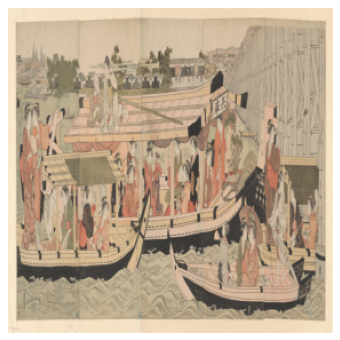

In [18]:
# Посмотрим содержимое датасета 
show_batch(train_pic_ds)

torch.Size([3, 286, 286])


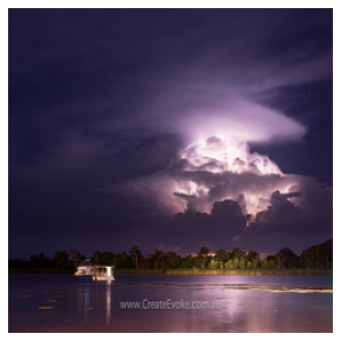

In [19]:
# Посмотрим содержимое датасета 
show_batch(train_foto_ds)

## 3. Создание моделей

In [20]:
def initialize_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight.data, 0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

In [21]:
# Генератор
class GeneratorUnet(nn.Module):
    def __init__(self):
        super(GeneratorUnet, self).__init__()
        # базовое количество карт
        self.chanel = 64
        
        # Сеть энкодера  
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.chanel, kernel_size=4, stride=2, padding=1, bias = False),
            nn.LeakyReLU(0.2, inplace=True)  
        ) #256 -> 128 
        
        self.down2 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel, out_channels=self.chanel*2, kernel_size=4, stride=2, padding=1, bias = False),
            nn.InstanceNorm2d(self.chanel*2),
            nn.LeakyReLU(0.2, inplace=True)  
        ) #128 -> 64
        
        self.down3 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*2, out_channels=self.chanel*4, kernel_size=4, stride=2, padding=1, bias = False),
            nn.InstanceNorm2d(self.chanel*4),
            nn.LeakyReLU(0.2, inplace=True)  
        ) #64 -> 32
        
        self.down4 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*4, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = False),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        ) #32 -> 16
        
        self.down5 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*8, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = False),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        ) #16 -> 8
        
        
        self.down6 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*8, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = False),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        ) #8 -> 4
        
        self.down7 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*8, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = False),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        ) #4 -> 2
        
        self.down8 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*8, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1, bias = False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        ) #4 -> 1
        
         # Сеть декодера 
        
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*8, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        )
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*16, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        )
        
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*16, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        )
        
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*16, out_channels=self.chanel*8, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5)
        )
        
        
        self.up5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*16, out_channels=self.chanel*4, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.chanel*4),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.5)
        )
        
        self.up6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*8, out_channels=self.chanel*2, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.chanel*2),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.5)
        )
        
        self.up7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*4, out_channels=self.chanel, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(self.chanel),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.5)
        )
        
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(in_channels=self.chanel*2, out_channels=3, kernel_size=4, stride=1, padding=1, bias = True),
            nn.Tanh()     
        )
        
    
    def forward(self, x):
        
        
        d1 = self.down1(x)  # 128х128
        d2 = self.down2(d1) # 64x64
        d3 = self.down3(d2) # 32х32
        d4 = self.down4(d3) # 16x16
        d5 = self.down5(d4) # 8x8
        d6 = self.down6(d5) # 4x4
        d7 = self.down7(d6) # 2x2
        d8 = self.down8(d7) # 1x1
        
        u1 = self.up1(d8)                         # 2x2
        u2 = self.up2(torch.cat([u1,d7],axis=1))  # 4x4
        u3 = self.up3(torch.cat([u2,d6],axis=1))  # 8x8
        u4 = self.up4(torch.cat([u3,d5],axis=1))  # 16x16
        u5 = self.up5(torch.cat([u4,d4],axis=1))  # 32x32
        u6 = self.up6(torch.cat([u5,d3],axis=1))  # 64x64
        u7 = self.up7(torch.cat([u6,d2],axis=1))  # 128x128 

        return self.final(torch.cat([u7,d1],axis=1))

In [22]:
# Блок Реснет 
class ResNetBlock(nn.Module):
    def __init__(self, channels):
        super(ResNetBlock, self).__init__()
        self.resnet  = nn.Sequential(
               
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, bias = True),
            nn.InstanceNorm2d(channels),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True), 
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, bias = True),
            nn.InstanceNorm2d(channels),

        )
        
    def forward(self, x):
        return x + self.resnet(x)

In [23]:
# Генератор
class GeneratorResNet(nn.Module):
    def __init__(self):
        super(GeneratorResNet, self).__init__()
        # базовое количество карт
        self.chanel = 64
        
        # Сеть энкодера  
        
        self.input = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=3, out_channels=self.chanel, kernel_size=7, stride=1, padding=0, bias = True),
            nn.ReLU(inplace=True)  
        ) #256 -> 256
        
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel, out_channels=self.chanel*2, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*2),
            nn.ReLU(inplace=True) 
        ) #256 -> 128 
        
        self.down2 = nn.Sequential(
            nn.Conv2d(in_channels=self.chanel*2, out_channels=self.chanel*4, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*4),
            nn.ReLU(inplace=True)    
        ) #128 -> 64
        
      
        self.resnet1 = ResNetBlock(self.chanel*4)
        self.resnet2 = ResNetBlock(self.chanel*4)
        self.resnet3 = ResNetBlock(self.chanel*4)
        self.resnet4 = ResNetBlock(self.chanel*4)
        self.resnet5 = ResNetBlock(self.chanel*4)
        self.resnet6 = ResNetBlock(self.chanel*4)
        self.resnet7 = ResNetBlock(self.chanel*4)
        self.resnet8 = ResNetBlock(self.chanel*4)
        self.resnet9 = ResNetBlock(self.chanel*4)
        
        
         # Сеть декодера 
        
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*4, out_channels=self.chanel*2, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel*2),
            nn.ReLU(inplace=True)  
       
        ) # 64 -> 128
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.chanel*2, out_channels=self.chanel, kernel_size=4, stride=2, padding=1, bias = True),
            nn.InstanceNorm2d(self.chanel),
            nn.ReLU(inplace=True)  
        ) # 128 -> 256
        
        
        
        self.out = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels=self.chanel, out_channels=3, kernel_size=7, stride=1, padding=0, bias = True),  
            nn.Tanh()     
        )
        
    
    def forward(self, x):
        
        x = self.input(x)   # 256x256
        x = self.down1(x)   # 128x128
        x = self.down2(x)   # 64x64
      
        x = self.resnet1(x)
        x = self.resnet2(x)
        x = self.resnet3(x)
        x = self.resnet4(x)
        x = self.resnet5(x)
        x = self.resnet6(x)
        x = self.resnet7(x)
        x = self.resnet8(x)
        x = self.resnet9(x) # 64x64
        
        
        x = self.up1(x)  # 128x128
        x = self.up2(x)  # 256x256

        return self.out(x)

In [24]:
# Создаем генераторы  и тестируем 
generator_AB = GeneratorResNet()
generator_BA = GeneratorResNet()
#generator_AB = GeneratorUnet()
#generator_BA = GeneratorUnet()
generator_AB = generator_AB.to(device)
generator_BA = generator_BA.to(device)

In [25]:
# Инициализируем веса
generator_AB.apply(initialize_weights)
generator_BA.apply(initialize_weights)
None

In [26]:
from torchsummary import summary

In [27]:
# Параметры Генератора 
print(summary(generator_AB, input_size = (3,256,256), batch_size = -1,  device='cuda'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 128, 128]         131,200
    InstanceNorm2d-5        [-1, 128, 128, 128]               0
              ReLU-6        [-1, 128, 128, 128]               0
            Conv2d-7          [-1, 256, 64, 64]         524,544
    InstanceNorm2d-8          [-1, 256, 64, 64]               0
              ReLU-9          [-1, 256, 64, 64]               0
  ReflectionPad2d-10          [-1, 256, 66, 66]               0
           Conv2d-11          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-12          [-1, 256, 64, 64]               0
          Dropout-13          [-1, 256, 64, 64]               0
             ReLU-14          [-1, 256,

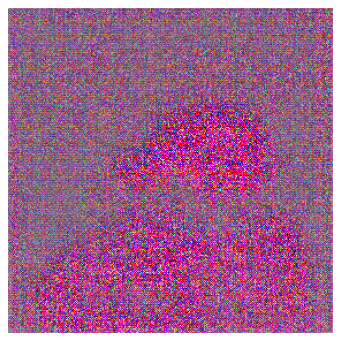

In [28]:
with torch.no_grad():
    batch_A  = next(iter(train_A_dl))
    show_images(generator_AB(batch_A[0].to(device)).to('cpu')[0])

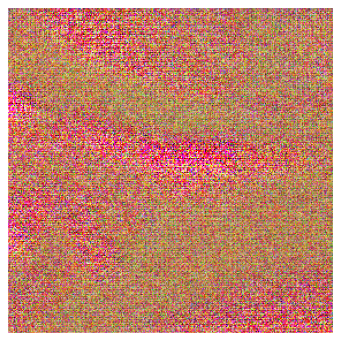

In [29]:
with torch.no_grad():
    batch_B  = next(iter(train_B_dl))
    show_images(generator_BA(batch_B[0].to(device)).to('cpu')[0])

In [30]:
# Дискриминатор 
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.chanel = 64
        self.discriminator = nn.Sequential(
            
            
            #  Входной с параметрами k=4, s=2, p=1 без нормализации 
            nn.Conv2d(3, self.chanel, kernel_size=4,  stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True), 
            
            # Два с параметрами k=4, s=2, p=1 с нормализацией 
            nn.Conv2d(self.chanel, self.chanel*2, kernel_size=4,  stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(self.chanel*2),
            nn.LeakyReLU(0.2, inplace=True), 

            
            # Один с параметрами k=4, s=1, p=1
            nn.Conv2d(self.chanel*2, self.chanel*8, kernel_size=4, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(self.chanel*8),
            nn.LeakyReLU(0.2, inplace=True), 
            
            # Выход с параметрами k=1, s=1, p=1
            nn.Conv2d(self.chanel*8, 1, kernel_size=4,  stride=1, padding=1, bias=True),

        )
        
    def forward(self, x):
        return self.discriminator(x)

In [31]:
# Создаем и тестируем 
discriminator_A = Discriminator()
discriminator_B = Discriminator()
discriminator_A = discriminator_A.to(device)
discriminator_B = discriminator_B.to(device)

In [32]:
discriminator_A.apply(initialize_weights)
discriminator_B.apply(initialize_weights)
None

In [33]:
# Параметры Генератора 
print(summary(discriminator_A,  input_size = (3,image_size,image_size), batch_size = -1,  device='cuda'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 512, 63, 63]       1,049,088
    InstanceNorm2d-7          [-1, 512, 63, 63]               0
         LeakyReLU-8          [-1, 512, 63, 63]               0
            Conv2d-9            [-1, 1, 62, 62]           8,193
Total params: 1,191,617
Trainable params: 1,191,617
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 74.54
Params size (MB): 4.55
Estimated Total Size (MB): 79.84
-------------------------------------

In [34]:
with torch.no_grad():
    test_d_A = discriminator_A(torch.empty(3,image_size,image_size).to(device)).cpu()
    patch_size = list(test_d_A.shape)
    patch_size.insert(0, batch_size)

In [35]:
patch_size

[1, 1, 62, 62]

## 4. Обучение моделей

In [36]:
# Параметры оптимизаторов и шедуллеров
opt_g = torch.optim.Adam(itertools.chain(generator_AB.parameters(), generator_BA.parameters()), lr=2e-4, betas=(0.5, 0.999))
opt_d_A = torch.optim.Adam(discriminator_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_d_B = torch.optim.Adam(discriminator_B.parameters(), lr=2e-4, betas=(0.5, 0.999))
scheduler_g = StepLR(opt_g, step_size=200, gamma=0.5)
scheduler_d_A = StepLR(opt_d_A, step_size=100, gamma=0.5)
scheduler_d_B = StepLR(opt_d_B, step_size=100, gamma=0.5)

In [37]:
# Тут накапливаем значения потерь генератора 
losses_g = []
losses_g_adv = []
losses_g_ind = []
losses_g_cycle = []
losses_g_pix = []
losses_d = []
losses_d_A = []
losses_d_B = []

In [38]:
# Номер стартовой эпохи
epoch_start = 0
# Загрузка модели
#load_state('/home/master/dls/art2foto_g_BA_epoch_799.tsm', generator_BA, opt_g)
#load_state('/home/master/dls/art2foto_g_AB_epoch_799.tsm', generator_AB, opt_g)
#load_state('/home/master/dls/art2foto_d_A_epoch_799.tsm', discriminator_A, opt_d_A)
#load_state('/home/master/dls/art2foto_d_B_epoch_799.tsm', discriminator_B, opt_d_B)
#set_lr(opt_d_A, lr = 1e-6)
#set_lr(opt_d_B, lr = 1e-6)

In [39]:
writer = SummaryWriter(comment=str(exp_name))
#writer.add_graph(generator_AB)
#writer.add_graph(discriminator_A)

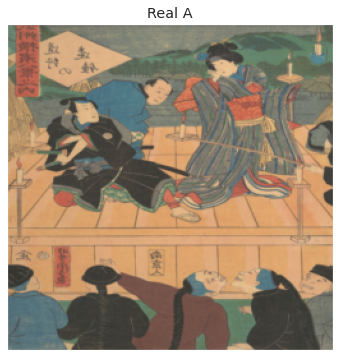

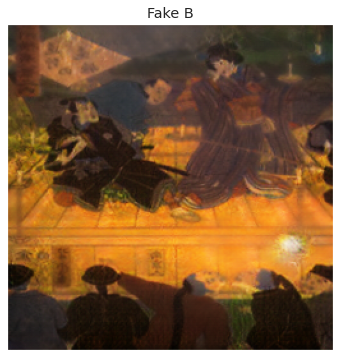

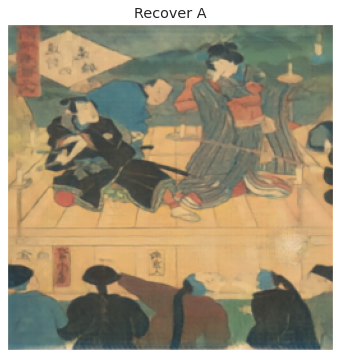

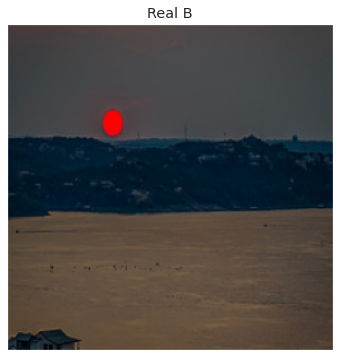

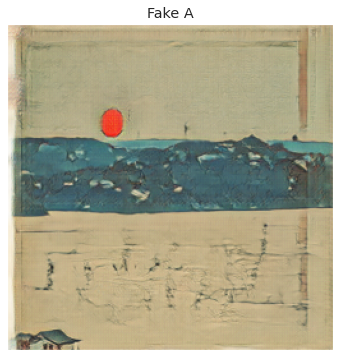

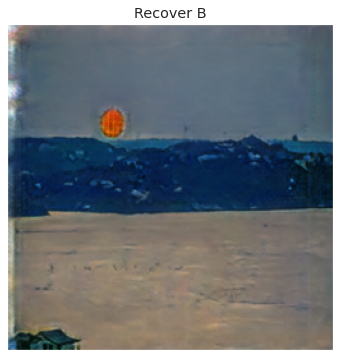

Эпоха: 799 loss_d: 0.16008058 loss_d_A: 0.1453198 loss_d_B: 0.1453198 loss_g: 1.117751 loss_g_ind: 0.19912 loss_g_cycle: 0.605519 loss_g_adv: 0.313112 loss_g_pix: 0.484429
lr_g 0.0002 lr_d_A 0.0002 lr_d_B 0.0002


In [40]:
# Количество эпох обучения
epochs =  800
# Количество батчей в одной эпохе
samples_per_epoch = 250
# Коэфициенты лоссов 
lambda_cycle = 10
lambda_idn = 5
lambda_pix = 1
# Размер буфера для обучения дискриминатора 
len_buf = 50
# Учитывать или нет соответсвующий лосс в общем лоссе генератора 
# Их будем вычислять в любом случае как некие критериии "похожести", но учитывать только если True 
idn = True
pix = False 

# чистим кеш 
torch.cuda.empty_cache()

# Получим данные для валидации
test_batch_A = next(iter(test_A_dl))[0]
test_batch_B = next(iter(test_B_dl))[0]


# Инициализируем буфер 
generator_AB.eval()
generator_BA.eval()


# Инициализируем буфер 
generator_AB.eval()
generator_BA.eval()
with torch.no_grad():
    ImgBuff = ImageBuffer(len_buf)
    for i in range(len_buf):
        Real_A  = next(iter(train_A_dl))[0]
        Real_B  = next(iter(train_B_dl))[0]
        Real_A, Real_B = augmentation(Real_A, Real_B)
        Fake_A  = generator_BA(Real_B.to(device)).to('cpu').detach()
        Fake_B  = generator_AB(Real_A.to(device)).to('cpu').detach()
        Rcv_A   = generator_BA(Fake_B.to(device)).to('cpu').detach()
        Rcv_B   = generator_AB(Fake_A.to(device)).to('cpu').detach()
        ImgBuff.push((Real_A.detach(), Fake_A, Rcv_A, Real_B.detach(), Fake_B, Rcv_B))

# Основной цикл обучения
# Бежим по эпохам
for epoch in range(epoch_start, epoch_start+epochs):
    
    # для накопления статистики по эпохе 
    losses_g_epoch = []
    losses_g_adv_epoch = []
    losses_g_ind_epoch = []
    losses_g_cycle_epoch = []
    losses_g_pix_epoch = []

    losses_d_epoch = []
    losses_d_A_epoch = []
    losses_d_B_epoch = []
    
        
    # Бежим батчами по датасету 
    for _ in tqdm(range(samples_per_epoch)):
        
        
        # Модели в трейн
        generator_AB.train()
        generator_BA.train()
        discriminator_A.train()
        discriminator_B.train()
        
        # Обучение генератора
        
        # Зануляем градиенты генератора 
        opt_g.zero_grad()
       
        # Готовим данные 
        
        batch_A  = next(iter(train_A_dl))[0]
        batch_B  = next(iter(train_B_dl))[0]
        
        Real_A, Real_B  = augmentation(batch_A, batch_B)
                        
        Real_A = Real_A.to(device) 
        Real_B = Real_B.to(device) 
        # Считаем Fake и Recov
        # Real_A -> Gen_AB -> Fake_B -> Gen_BA -> rcv_A
        # Real_B -> Gen_BA -> Fake_A -> Gen_AB -> rcv_B
        Fake_A = generator_BA(Real_B)
        Fake_B = generator_AB(Real_A)
        Rcv_A =  generator_BA(Fake_B)
        Rcv_B =  generator_AB(Fake_A)
        # Считаем Predict 
        
        
        pred_real_A = discriminator_A(Real_A)
        pred_fake_A = discriminator_A(Fake_A)
        pred_real_B = discriminator_B(Real_B)
        pred_fake_B = discriminator_B(Fake_B)
        
        
        # Считаем лоссы генератора 
        
        # Loss на основе оценки данной дискриминаторами
        loss_adv_AB = nn.MSELoss()(pred_fake_B, torch.ones(patch_size).to(device)) 
        loss_adv_BA = nn.MSELoss()(pred_fake_A, torch.ones(patch_size).to(device))  
        loss_adv = (loss_adv_AB + loss_adv_BA) * 0.5
        
        # Cycle loss это L1 между rcv_A и Real_A, rcv_B и Real_B
        loss_cycle_A = nn.L1Loss()(Rcv_A, Real_A)  
        loss_cycle_B = nn.L1Loss()(Rcv_B, Real_B)  
        loss_cycle = lambda_cycle * (loss_cycle_A + loss_cycle_B) * 0.5
        
        # Ind loss L1 
        loss_idn_A = nn.L1Loss()(generator_BA(Real_A), Real_A)  
        loss_idn_B = nn.L1Loss()(generator_AB(Real_B), Real_B)  
        loss_idn = lambda_idn * (loss_idn_A + loss_idn_B) * 0.5
        
        # Pix loss L1 
        loss_pix_A = nn.L1Loss()(generator_AB(Real_A), Real_B)  
        loss_pix_B = nn.L1Loss()(generator_BA(Real_B), Real_A)  
        loss_pix = lambda_pix * (loss_pix_A + loss_pix_B) * 0.5
        
   
        loss_g = loss_adv  +  loss_cycle
        
        if pix == True:
            loss_g = loss_g + loss_pix
      
        if idn == True:
            loss_g = loss_g + loss_idn
        
        # Обратный проход
        loss_g.backward()
        
        # Делаем шаг генератора
        opt_g.step()
        
        # Сохраняем в буфер сгенерированые изображения, а из буфера получаем ранее сгенирированое изображение
        Real_A, Fake_A, Rcv_A, Real_B, Fake_B, Rcv_B = ImgBuff.random_update((Real_A.detach(), Fake_A.detach(), Rcv_A.detach(), Real_B.detach(), Fake_B.detach(),  Rcv_B.detach()))
        
        
        # Сохраняем лосс генератора 
        
        losses_g_epoch.append(loss_g.item())
        losses_g_adv_epoch.append(loss_adv.item())
        losses_g_ind_epoch.append(loss_idn.item())
        losses_g_cycle_epoch.append(loss_cycle.item())
        losses_g_pix_epoch.append(loss_pix.item())
      
        
        # Обучение дискриминатора А
        
        discriminator_A.train()
        
        
        # Зануляем градиенты Дискриминатора A 
        opt_d_A.zero_grad()
        
        # Считаем лосс
        loss_real = nn.MSELoss()(discriminator_A(Real_A.to(device)), torch.ones(patch_size).to(device)) 
        loss_fake = nn.MSELoss()(discriminator_A(Fake_A.to(device)), torch.zeros(patch_size).to(device)) 
        loss_d_A =  (loss_real + loss_fake) * 0.5
        
        # Обратный проход
        loss_d_A.backward()
        
        # Делаем шаг дискриминатора  
        opt_d_A.step()
        
        # Сохраняем лосс дискриминатора А
        losses_d_A_epoch.append(loss_d_A.item())
        
        # Обучение дискриминатора B
        discriminator_B.train()
        
        # Зануляем градиенты Дискриминатора B
        opt_d_B.zero_grad()
        

        # Считаем лосс
        loss_real = nn.MSELoss()(discriminator_B(Real_B.to(device)), torch.ones(patch_size).to(device)) 
        loss_fake = nn.MSELoss()(discriminator_B(Fake_B.to(device)), torch.zeros(patch_size).to(device)) 
        loss_d_B =  (loss_real + loss_fake) * 0.5
        
        # Обратный проход
        loss_d_B.backward()
        
        # Делаем шаг дискриминатора  
        opt_d_B.step()
        
        # Сохраняем лосс дискриминатора B
        losses_d_B_epoch.append(loss_d_B.item())
        
        loss_d = (loss_d_A + loss_d_B) * 0.5 
        # Сохраняем лосс дискриминатора B
        losses_d_epoch.append(loss_d.item())   
        
    
    # Считаем лоссы по эпохе 
    
    losses_g.append(np.mean(losses_g_epoch))
    losses_g_adv.append(np.mean(losses_g_adv_epoch))
    losses_g_ind.append(np.mean(losses_g_ind_epoch))
    losses_g_cycle.append(np.mean(losses_g_cycle_epoch))
    losses_g_pix.append(np.mean(losses_g_pix_epoch))

    losses_d.append(np.mean(losses_d_epoch))
    losses_d_A.append(np.mean(losses_d_A_epoch))
    losses_d_B.append(np.mean(losses_d_B_epoch))
    
    # Отложеный старт шедуллера
    #if epoch >= 200:
    #    scheduler_d_A.step()
    #    scheduler_d_B.step()
    #    scheduler_g.step()
    
    generator_AB.eval()
    generator_BA.eval()
    
    
    # Выводим картинки
    clear_output(wait=True)
    
    show_images(Real_A.cpu(), title = 'Real A')
    show_images(Fake_B.cpu(), title = 'Fake B')
    show_images(Rcv_A.cpu(), title = 'Recover A')
    
    
    show_images(Real_B.cpu(), title = 'Real B')
    show_images(Fake_A.cpu(), title = 'Fake A')
    show_images(Rcv_B.cpu(), title = 'Recover B')
    
    plt.show()
    
    with torch.no_grad():
        test_fake_A = generator_BA(test_batch_B.to(device)).to('cpu')
        test_fake_B = generator_AB(test_batch_A.to(device)).to('cpu')
        test_rcv_A = generator_BA(test_fake_B.to(device)).to('cpu')
        test_rcv_B = generator_AB(test_fake_A.to(device)).to('cpu')
        
    
    
    # Выгружаем статистику в TensorBoard
    writer.add_scalar('loss_d', np.around(losses_d[-1],8), epoch)
    writer.add_scalar('loss_d_A', np.around(losses_d_A[-1],8), epoch)
    writer.add_scalar('loss_d_B', np.around(losses_d_B[-1],8), epoch)
    writer.add_scalar('loss_g', np.around(losses_g[-1],8), epoch)
    writer.add_scalar('loss_g_ind', np.around(losses_g_ind[-1],8), epoch)
    writer.add_scalar('loss_g_cycle', np.around(losses_g_cycle[-1],8), epoch)
    writer.add_scalar('loss_g_adv', np.around(losses_g_adv[-1],8), epoch)
    writer.add_scalar('loss_g_pix', np.around(losses_g_pix[-1],8), epoch)
    writer.add_scalar('lr_g', opt_g.state_dict()['param_groups'][0]['lr'], epoch)
    writer.add_scalar('lr_A', opt_d_A.state_dict()['param_groups'][0]['lr'], epoch)
    writer.add_scalar('lr_B', opt_d_B.state_dict()['param_groups'][0]['lr'], epoch)
    writer.add_image('Real_A', make_grid(denorm(test_batch_A.cpu()),  nrow=4).permute(1, 2, 0), epoch, dataformats='HWC')
    writer.add_image('Real_B', make_grid(denorm(test_batch_B.cpu()), nrow=4).permute(1, 2, 0), epoch, dataformats='HWC')
    writer.add_image('Fake_A', make_grid(denorm(test_fake_A.cpu()), nrow=4).permute(1, 2, 0), epoch, dataformats='HWC')
    writer.add_image('Fake_B', make_grid(denorm(test_fake_B.cpu()), nrow=4).permute(1, 2, 0), epoch, dataformats='HWC')
    writer.add_image('Rcv_A', make_grid(denorm(test_rcv_A.cpu()), nrow=4).permute(1, 2, 0), epoch, dataformats='HWC')
    writer.add_image('Rcv_B', make_grid(denorm(test_rcv_B.cpu()), nrow=4).permute(1, 2, 0), epoch, dataformats='HWC')
    writer.flush()
    
    # Печатаем статистику обучения по эпохе 
    print('Эпоха:', epoch, 
        'loss_d:', np.around(losses_d[-1],8),
        'loss_d_A:', np.around(losses_d_A[-1],8),
        'loss_d_B:', np.around(losses_d_A[-1],8),
        'loss_g:', np.around(losses_g[-1],6),
        'loss_g_ind:', np.around(losses_g_ind[-1],6),
        'loss_g_cycle:', np.around(losses_g_cycle[-1],6),
        'loss_g_adv:', np.around(losses_g_adv[-1],6),
        'loss_g_pix:', np.around(losses_g_pix[-1],6))
    print('lr_g', opt_g.state_dict()['param_groups'][0]['lr'],
          'lr_d_A', opt_d_A.state_dict()['param_groups'][0]['lr'],
          'lr_d_B', opt_d_B.state_dict()['param_groups'][0]['lr'])
    # сохраняем результаты обучения 
    if epoch % 50 == 1:
        file_name = exp_name + '_d_A_epoch_' + str(epoch) +  '.tsm'
        save_state(file_name, discriminator_A, opt_d_A)
        file_name = exp_name + '_d_B_epoch_' + str(epoch) +  '.tsm'
        save_state(file_name, discriminator_B, opt_d_B)
        file_name = exp_name + '_g_AB_epoch_' + str(epoch) + '.tsm'
        save_state(file_name, generator_AB, opt_g)
        file_name = exp_name + '_g_BA_epoch_' + str(epoch) + '.tsm'
        save_state(file_name, generator_BA, opt_g)

In [41]:
file_name = exp_name + '_d_A_epoch_' + str(epoch) +  '.tsm'
save_state(file_name, discriminator_A, opt_d_A)
file_name = exp_name + '_d_B_epoch_' + str(epoch) +  '.tsm'
save_state(file_name, discriminator_B, opt_d_B)
file_name = exp_name + '_g_AB_epoch_' + str(epoch) + '.tsm'
save_state(file_name, generator_AB, opt_g)
file_name = exp_name + '_g_BA_epoch_' + str(epoch) + '.tsm'
save_state(file_name, generator_BA, opt_g)

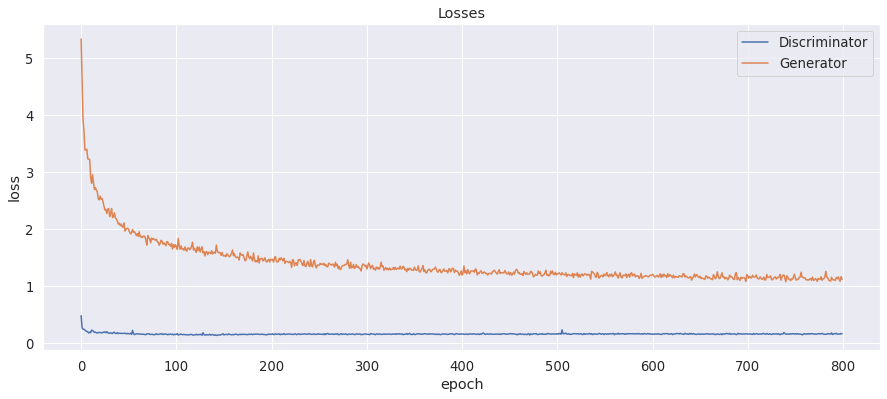

In [42]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

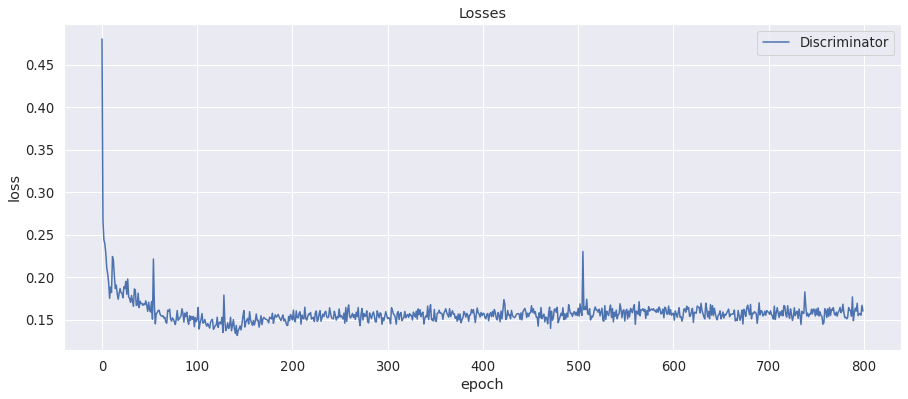

In [43]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

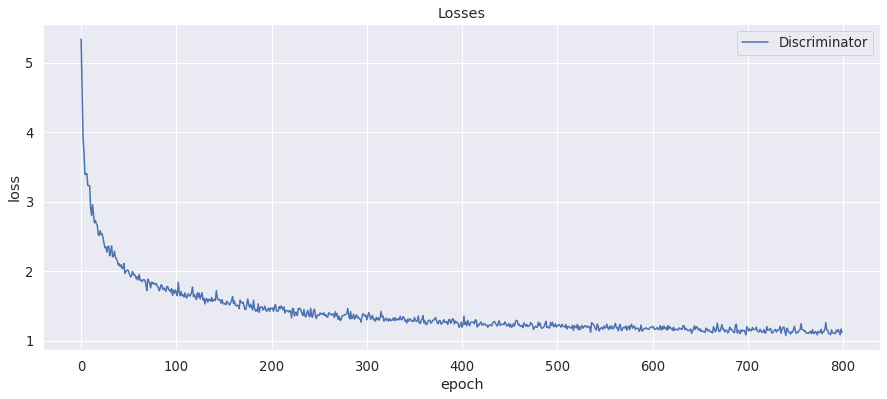

In [44]:
plt.figure(figsize=(15, 6))
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');